]<a href="https://colab.research.google.com/github/YuanGongND/ast/blob/master/colab/AST_Inference_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [AST: Audio Spectrogram Transformer](https://www.isca-speech.org/archive/interspeech_2021/gong21b_interspeech.html)

This colab script contains the implementation of a minimal demo of pretrained Audio Spectrogram Transformer (AST) inference and attention visualization.

This script is self-contained and can be run in one click, replace the `sample_audio_path` to test your own audio.

Please cite our paper if you find this repository useful.

```
@inproceedings{gong21b_interspeech,
  author={Yuan Gong and Yu-An Chung and James Glass},
  title={{AST: Audio Spectrogram Transformer}},
  year=2021,
  booktitle={Proc. Interspeech 2021},
  pages={571--575},
  doi={10.21437/Interspeech.2021-698}
}
```
For more information, please check https://github.com/YuanGongND/ast

With the following hyperparameters:

Freezing layers 1-10

## Step 1. Install and import required packages.

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/liaolc/ASTonGTZAN.git
    sys.path.append('./ast')
%cd ASTonGTZAN/

! pip install timm==0.4.5
! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = './pretrained_models'
if os.path.exists('./pretrained_models') == False:
  os.mkdir('./pretrained_models')
#os.environ['TORCH_HOME'] = '/content/ast/pretrained_models'
# if os.path.exists('/content/ast/pretrained_models') == False:
#   os.mkdir('/content/ast/pretrained_models')
import torch
import torchaudio
import timm
import numpy as np
from torch.cuda.amp import autocast
import IPython

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running in Colab.
Cloning into 'ASTonGTZAN'...
remote: Enumerating objects: 6309, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 6309 (delta 39), reused 44 (delta 23), pack-reused 6244
Receiving objects: 100% (6309/6309), 1.94 GiB | 15.63 MiB/s, done.
Resolving deltas: 100% (164/164), done.
Updating files: 100% (3160/3160), done.
/content/ASTonGTZAN
  Using cached timm-0.4.5-py3-none-any.whl (287 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-non

## Step 2. Create AST model and load AudioSet pretrained weights.
The pretrained model achieves 45.93 mAP on the AudioSet evaluation set, which is the best single model in the paper.

In [ ]:
from src.models import ASTModel

# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list

def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    # SpecAug -- freqm & timem specified in run.py, set to 0 for eval set.
    freqm = torchaudio.transforms.FrequencyMasking(48)
    timem = torchaudio.transforms.TimeMasking(192)
    fbank = torch.transpose(fbank, 0, 1)
    # this is just to satisfy new torchaudio version, which only accept [1, freq, time]
    fbank = fbank.unsqueeze(0)
    if self.freqm != 0:
        fbank = freqm(fbank)
    if self.timem != 0:
        fbank = timem(fbank)
    # squeeze it back, it is just a trick to satisfy new torchaudio version
    fbank = fbank.squeeze(0)
    fbank = torch.transpose(fbank, 0, 1)



    fbank = (fbank - (-2.2568474)) / (3.2726912 * 2)
    return fbank


def load_label(label_csv):
    with open(label_csv, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        lines = list(reader)
    labels = []
    ids = []  # Each label has a unique id such as "/m/068hy"
    for i1 in range(1, len(lines)):
        id = lines[i1][1]
        label = lines[i1][2]
        ids.append(id)
        labels.append(label)
    return labels

# Create an AST model and download the AudioSet pretrained weights

#layesr 1-6 frozen
#audioset_mdl_url = 'https://www.dropbox.com/scl/fi/9f5xn3r0hxa92guj3wt0k/freeze1-6_70acc.pth?rlkey=vfyncqn2okbmuhkmawti3it88&st=rpthc4jx&dl=1'

#layers 1-8 frozen
#audioset_mdl_url = 'https://www.dropbox.com/scl/fi/dz3hl8s3bgy93k67c139y/Freeze1-8_15epoch.pth?rlkey=xpsbwcwxmmontviwug6ccqaoj&st=7u7kqu0x&dl=1'

#layers 1-10 frozen
audioset_mdl_url = 'https://www.dropbox.com/scl/fi/evimzpnbvqjtc565r5kpe/Freeze1-10.pth?rlkey=c9i7o7zi48f344188b7bxldzc&st=0xyq13w1&dl=1'

if os.path.exists('/content/ASTonGTZAN/pretrained_models/audio_mdl.pth') == False:
  wget.download(audioset_mdl_url, out='/content/ASTonGTZAN/pretrained_models/audio_mdl.pth')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = '/content/ASTonGTZAN/pretrained_models/audio_mdl.pth'
# now load the visualization model
ast_mdl = ASTModelVis(label_dim=10, input_tdim=input_tdim, imagenet_pretrain=False, audioset_pretrain=False)
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location='cuda')
audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device("cuda:0"))
audio_model.eval()

# Load the AudioSet label set
label_csv = '/content/drive/MyDrive/ASTonGTZAN-main/egs/GTZAN/data/GTZAN_class_labels_indices.csv'       # label and indices for audioset data
labels = load_label(label_csv)

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: /content/ASTonGTZAN/pretrained_models/audio_mdl.pth


## Step 3. Load an audio and predict the sound class.
By default we test one sample from another dataset (VGGSound) that has not been seen during the model training.

For this very specific sample, it is a parrot mimicing human speech and there's a bird chirp in the middle, that's why the model predicts it is a mixture of speech and bird sound. This audio is extracted from a Youtube video, and the video looks like this (note: only audio is used for prediction):

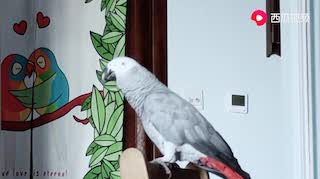

Replace the `sample_audio_path` to test your own audio.

In [ ]:
!pwd
!rm -r sample_audios

/content/ASTonGTZAN
rm: cannot remove 'sample_audios': No such file or directory


In [ ]:
# Get a sample audio and make feature for predict
# change url to play with the script
#sample_audio_path = 'https://www.dropbox.com/s/kx8s8irzwj6nbeq/glLQrEijrKg_000300.flac?dl=1'

# # some other samples
blues_1_path = 'https://www.dropbox.com/scl/fi/5tlemws49u9kw2c4uti8p/blues.00008.wav?rlkey=0r86m6xwk8i2iazkhztthchvg&st=se4gqo1k&dl=1'
blues_2_path = 'https://www.dropbox.com/scl/fi/sof96sday5lq2w7hnx81i/blues2.00008.wav?rlkey=wduqaqwgfjsgqnpmv4wumxn5k&st=cgknafg5&dl=1'
blues_3_path = 'https://www.dropbox.com/scl/fi/3i96vsw3twsxdg2tcvq5l/blues3.00008.wav?rlkey=qn5opt8sy9sz8wbhkiws0vrvm&st=dngpx4dx&dl=1'
#sample_audio_path = 'https://www.dropbox.com/s/omned2muw8cyunf/6jiO0tPLK7U_000090.flac?dl=1'

if os.path.exists('/content/ASTonGTZAN/sample_audios') == False:
  os.mkdir('/content/ASTonGTZAN/sample_audios')
if os.path.exists('/content/ASTonGTZAN/sample_audios/sample_audio.flac') == True:
  os.remove('/content/ASTonGTZAN/sample_audios/sample_audio.flac')
#wget.download(sample_audio_path, '/content/ast/sample_audios/sample_audio.flac')
wget.download(blues_1_path, '/content/ASTonGTZAN/sample_audios/blues.00008.wav')
wget.download(blues_2_path, '/content/ASTonGTZAN/sample_audios/blues2.00008.wav')
wget.download(blues_3_path, '/content/ASTonGTZAN/sample_audios/blues3.00008.wav')
feats1 = make_features('/content/ASTonGTZAN/sample_audios/blues.00008.wav', mel_bins=128)           # shape(1024, 128)
feats_data1 = feats1.expand(1, input_tdim, 128)           # reshape the feature
feats_data1 = feats_data1.to(torch.device("cuda:0"))
feats2 = make_features('/content/ASTonGTZAN/sample_audios/blues2.00008.wav', mel_bins=128)           # shape(1024, 128)
feats_data2 = feats2.expand(1, input_tdim, 128)           # reshape the feature
feats_data2 = feats_data2.to(torch.device("cuda:0"))
feats3 = make_features('/content/ASTonGTZAN/sample_audios/blues3.00008.wav', mel_bins=128)           # shape(1024, 128)
feats_data3 = feats3.expand(1, input_tdim, 128)           # reshape the feature
feats_data3 = feats_data3.to(torch.device("cuda:0"))
# do some masking of the input
#feats_data[:, :512, :] = 0.

# Make the prediction
with torch.no_grad():
  with autocast():
    output1 = audio_model.forward(feats_data1)
    output1 = torch.sigmoid(output1)
    output2 = audio_model.forward(feats_data2)
    output2 = torch.sigmoid(output2)
    output3 = audio_model.forward(feats_data3)
    output3 = torch.sigmoid(output3)
result_output1 = output1.data.cpu().numpy()[0]
result_output2 = output2.data.cpu().numpy()[0]
result_output3 = output3.data.cpu().numpy()[0]
results=[result_output1, result_output2, result_output3]
results=np.mean(results, axis=0)
print(result_output1)
print(result_output2)
print(result_output3)

sorted_indexes = np.argsort(results)[::-1]

# Print audio tagging top probabilities
print('Predict results:')
for k in range(10):
    print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], results[sorted_indexes[k]]))
print('Listen to the samples: ')
IPython.display.Audio('/content/ASTonGTZAN/sample_audios/blues.00008.wav')
IPython.display.Audio('/content/ASTonGTZAN/sample_audios/blues2.00008.wav')
IPython.display.Audio('/content/ASTonGTZAN/sample_audios/blues3.00008.wav')

[0.4497  0.0749  0.1985  0.03085 0.09076 0.2227  0.1573  0.01791 0.1749
 0.3682 ]
[0.2915  0.0551  0.1897  0.03568 0.05878 0.1506  0.1592  0.01653 0.1361
 0.3625 ]
[0.3584   0.05823  0.2289   0.04248  0.0662   0.1748   0.1245   0.015305
 0.112    0.313   ]
Predict results:
- blues: 0.3665
- rock: 0.3479
- country: 0.2057
- jazz: 0.1827
- metal: 0.1470
- reggae: 0.1410
- hiphop: 0.0719
- classical: 0.0627
- disco: 0.0363
- pop: 0.0166
Listen to the samples: 


## Step 4.a. Visualize the mean attention map of all attention heads for each layer
Note the model focuses on the middle high frequency bird chirp as well as the low frequency speech.

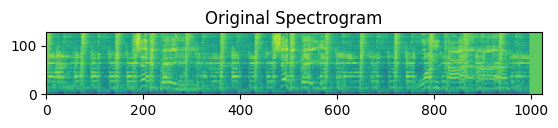

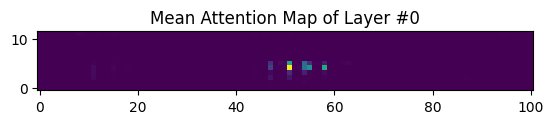

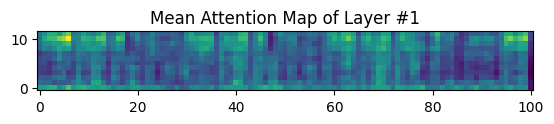

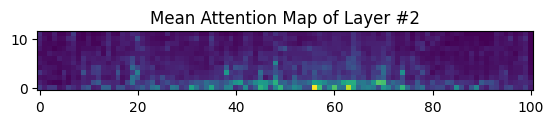

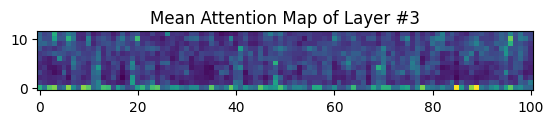

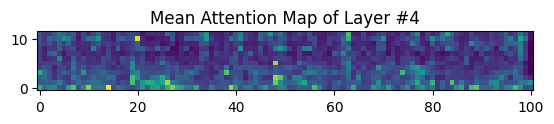

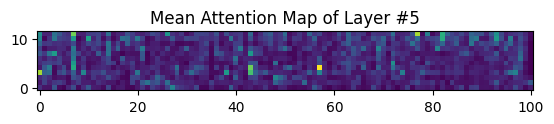

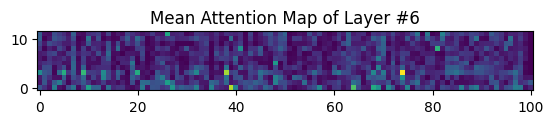

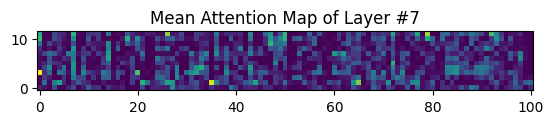

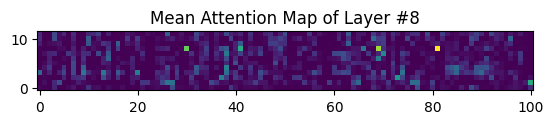

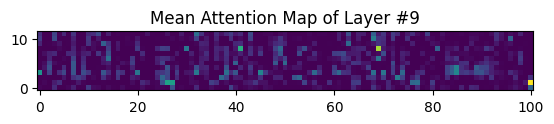

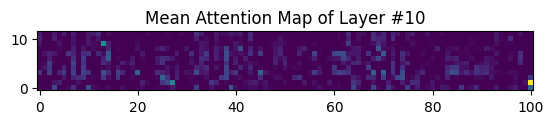

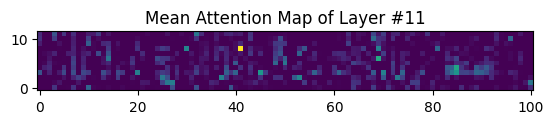

In [ ]:
from matplotlib import pyplot as plt
feats_data = feats_data1
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)
for i in range(len(att_list)):
  att_list[i] = att_list[i].data.cpu().numpy()
  att_list[i] = np.mean(att_list[i][0], axis=0)
  att_list[i] = np.mean(att_list[i][0:2], axis=0)
  att_list[i] = att_list[i][2:].reshape(12, 101)
  plt.imshow(att_list[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.savefig('onetoeight_mean_att_map_layer #{:d}.png'.format(i))
  plt.close()

In [ ]:
import csv
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score

#pred_url = 'https://www.dropbox.com/scl/fi/sfvm3rvfc007pjg622p4b/freeze6cum_predictions.csv?rlkey=14vxexo85eu0mgdqht1ct40fa&st=6qx3uk8k&dl=1'
pred_url = 'https://www.dropbox.com/scl/fi/5h10d0gq0gg0ax3xonojk/freeze8cum_predictionsviz.csv?rlkey=p7qc3cf29074rskwcj67xv4ay&st=f7uqrlqq&dl=1'
target_url = 'https://www.dropbox.com/scl/fi/8td34nbyk70cl4qhtwsqg/targetforviz.csv?rlkey=2dv1m6yqwjmvco3lyl8gom0pd&st=r3uvhwwn&dl=1'

if os.path.exists('/content/ASTonGTZAN/egs/GTZAN/data/pred.csv') == False:
  wget.download(pred_url, out='/content/ASTonGTZAN/egs/GTZAN/data/pred.csv')
if os.path.exists('/content/ASTonGTZAN/egs/GTZAN/data/target.csv') == False:
  wget.download(target_url, out='/content/ASTonGTZAN/egs/GTZAN/data/target.csv')
pred_path = '/content/ASTonGTZAN/egs/GTZAN/data/pred.csv'
target_path = '/content/ASTonGTZAN/egs/GTZAN/data/target.csv'



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7
 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 7 7 7 7 7 7 7 7 7 7 

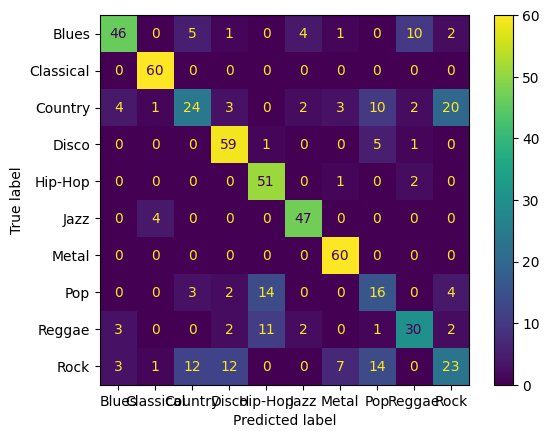

<Figure size 2000x2000 with 0 Axes>

In [ ]:
class_labels = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
kappa = []
df_actual = pd.read_csv(target_path)
#print(df_actual.info())
df_actual = df_actual.idxmax(axis='columns')
#print(df_actual.info())
df_pred = pd.read_csv(pred_path)
df_pred = df_pred.idxmax(axis='columns')
#print(df_pred.info())
df_pred = df_pred.values.astype(int)

df_actual = df_actual.values.astype(int)
print(df_actual)
print(df_pred)
#.astype(int)
#print(df_actual)
#print(df_actual.info())
#df = pd.concat([df_actual, df_pred], axis=1)
#print("df: ",df.info())
#df.rows = ['Actual', 'Predicted']
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cm = confusion_matrix(df_actual, df_pred, labels=labels)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.figure(figsize=(20, 20))
plt.show()

## Step 4.b. Visualize the attention map of each attention head of a specific layer
Note the attention map of heads are quite diverse.

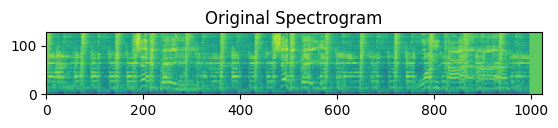

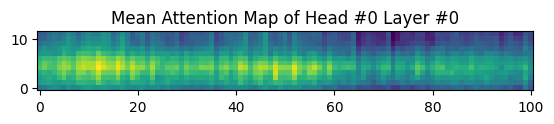

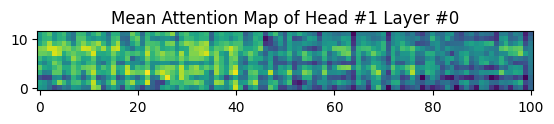

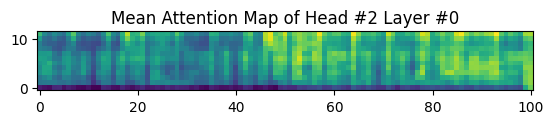

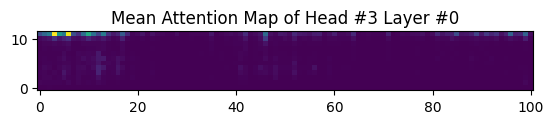

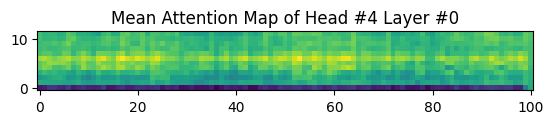

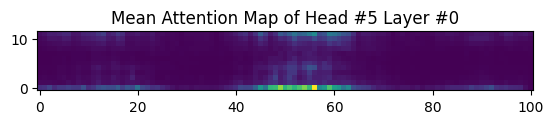

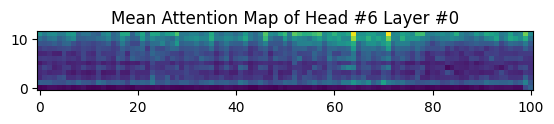

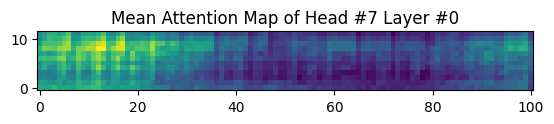

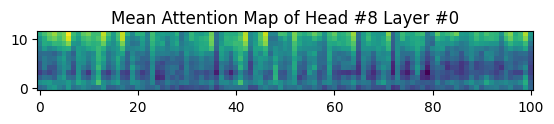

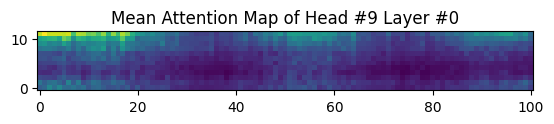

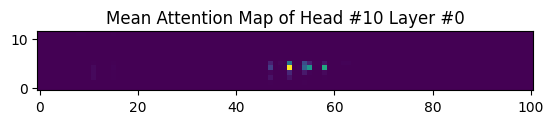

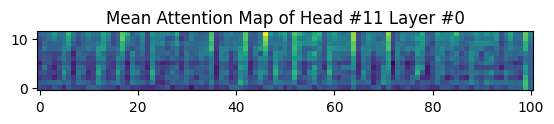

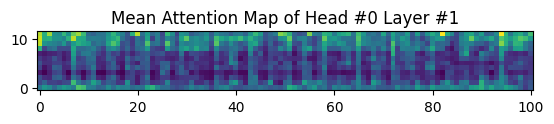

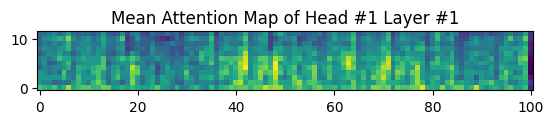

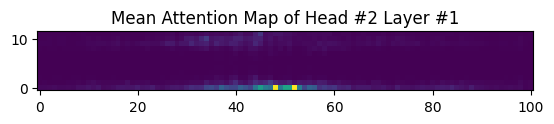

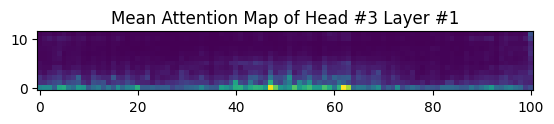

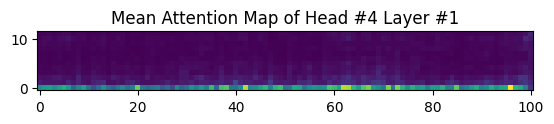

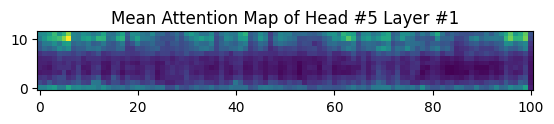

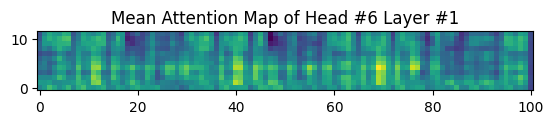

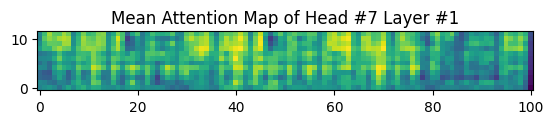

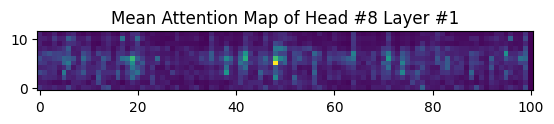

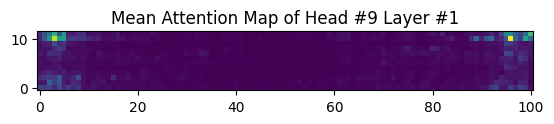

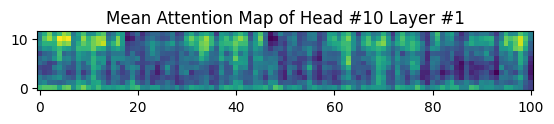

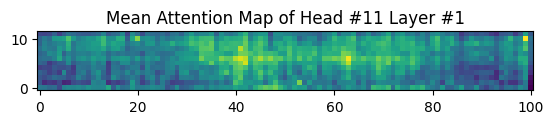

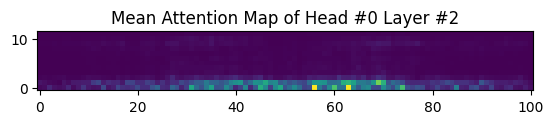

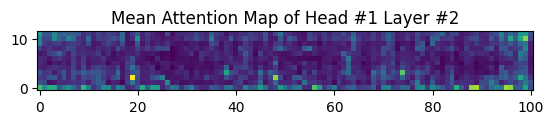

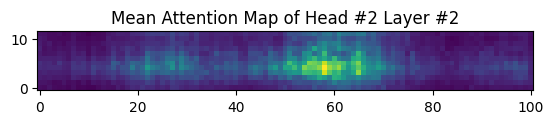

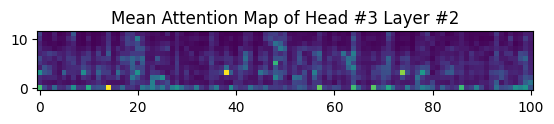

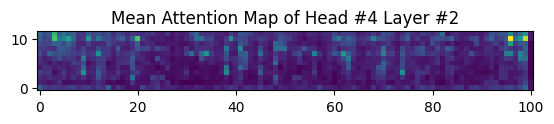

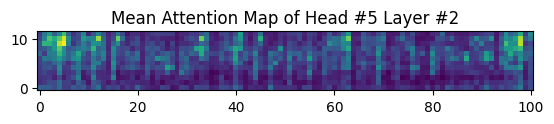

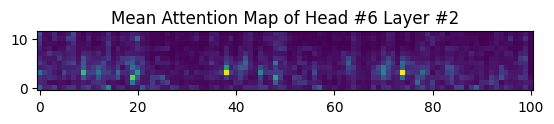

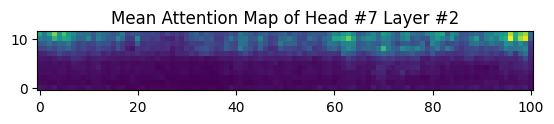

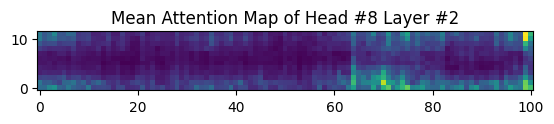

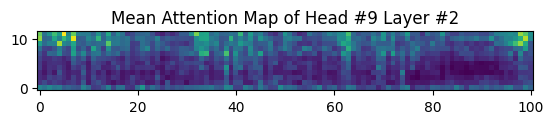

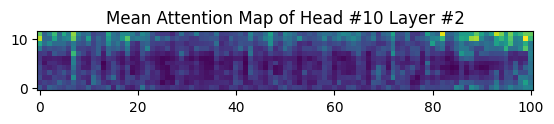

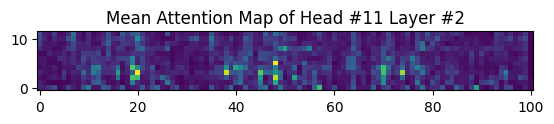

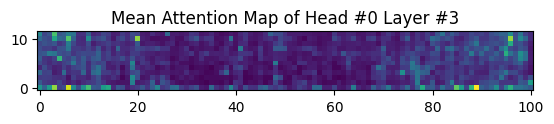

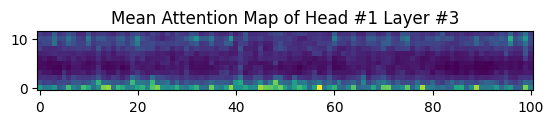

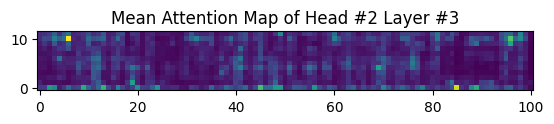

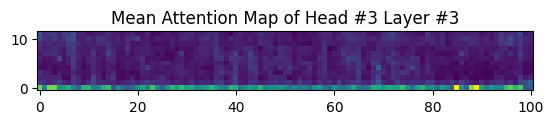

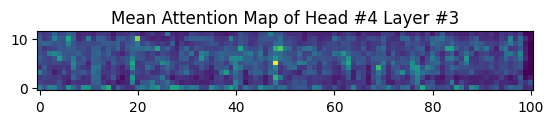

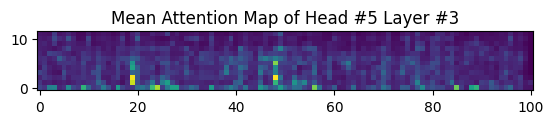

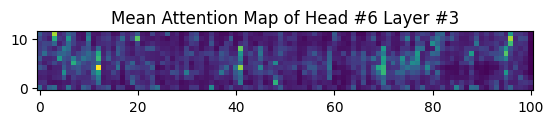

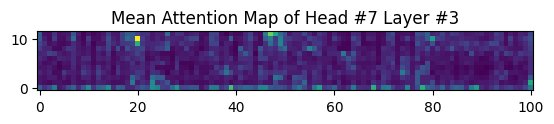

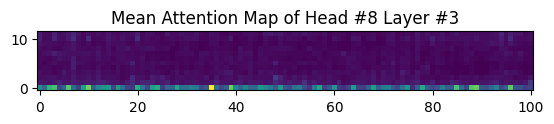

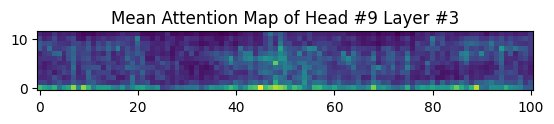

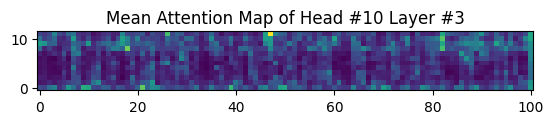

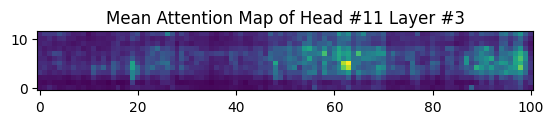

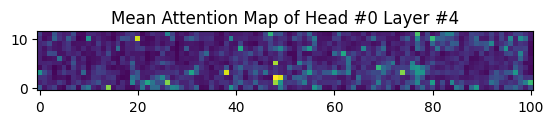

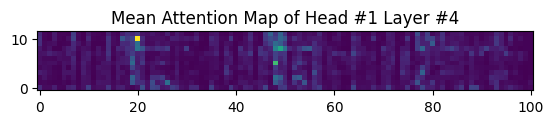

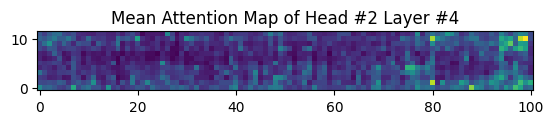

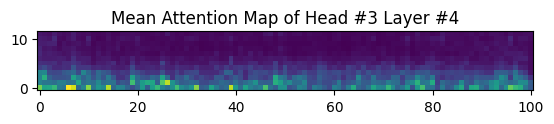

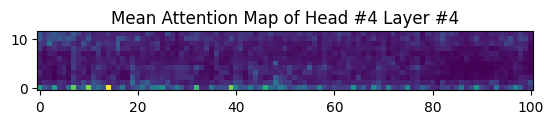

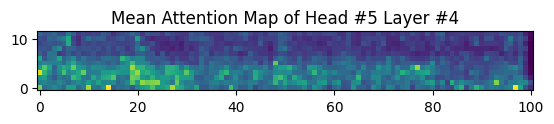

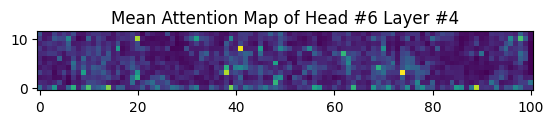

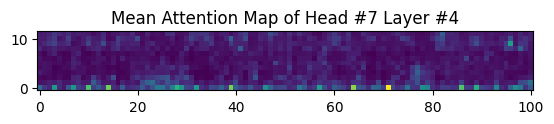

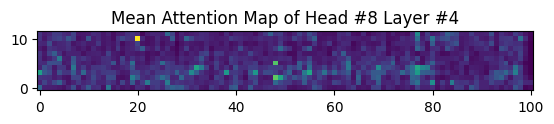

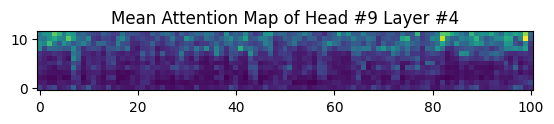

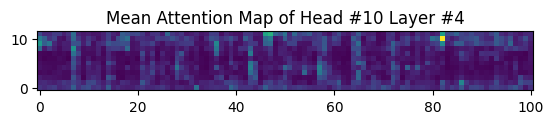

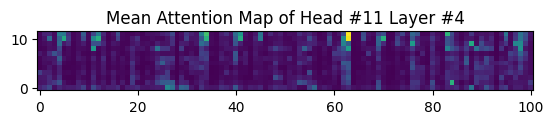

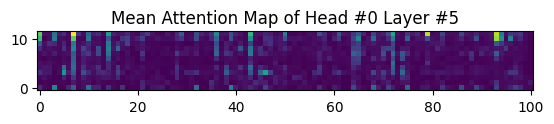

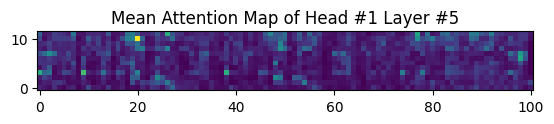

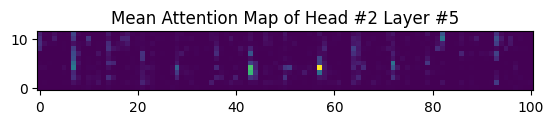

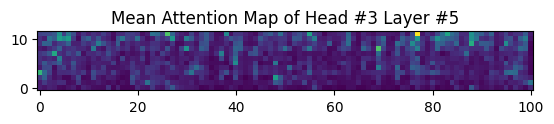

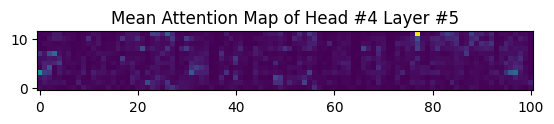

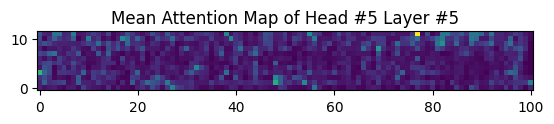

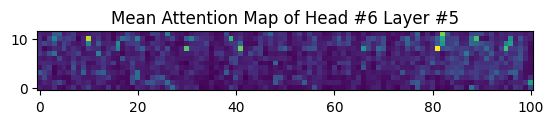

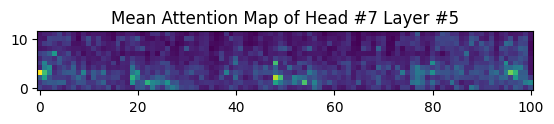

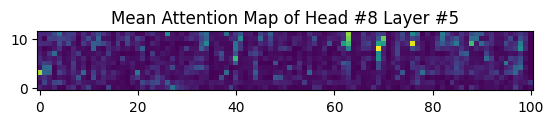

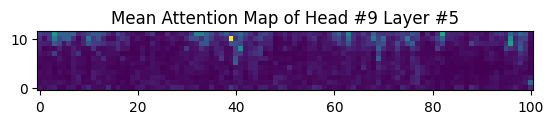

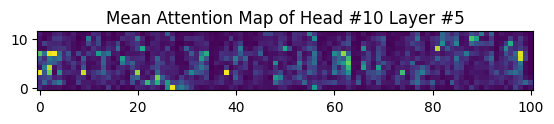

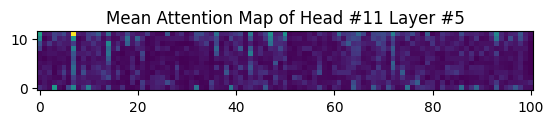

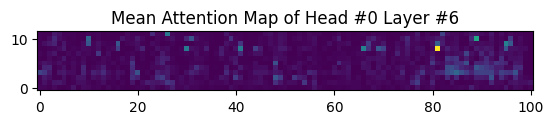

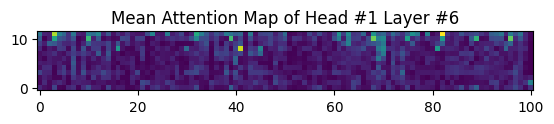

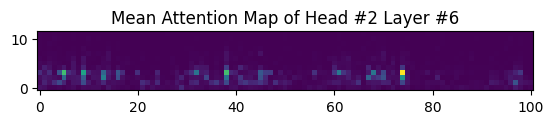

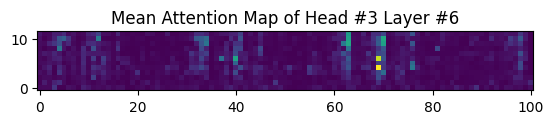

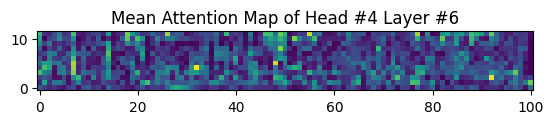

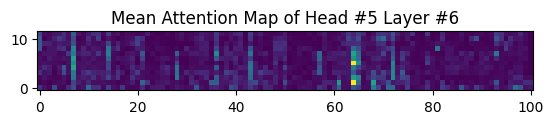

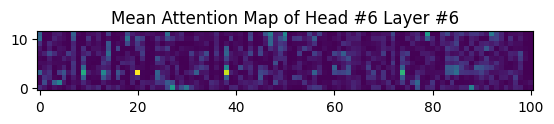

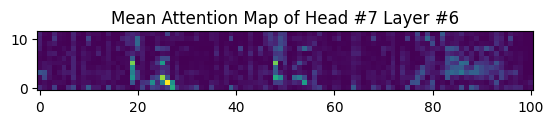

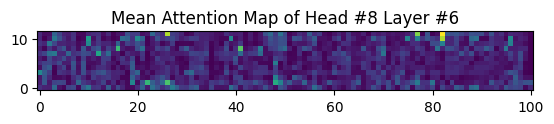

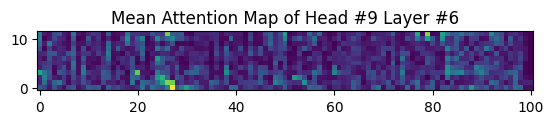

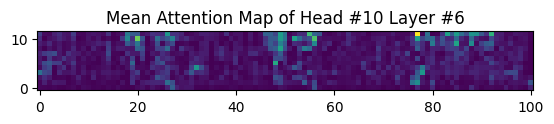

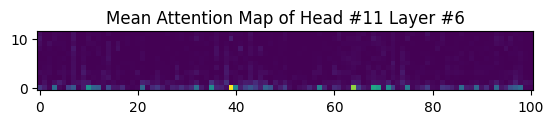

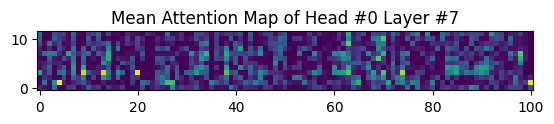

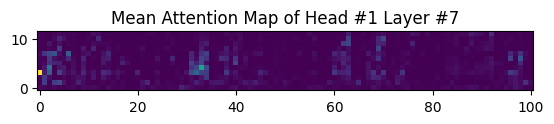

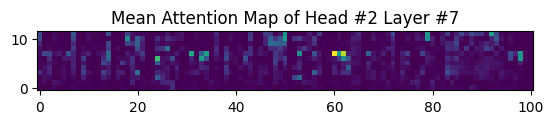

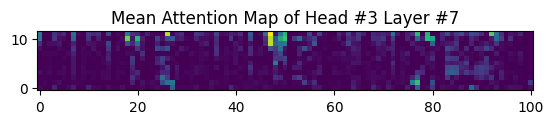

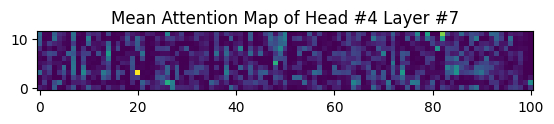

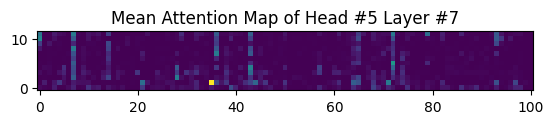

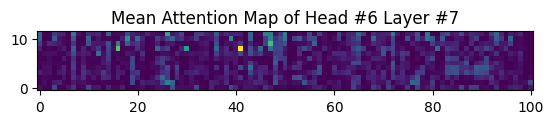

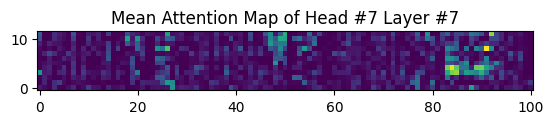

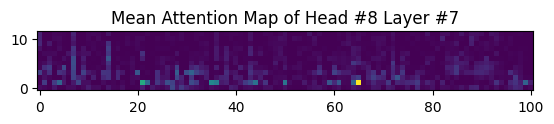

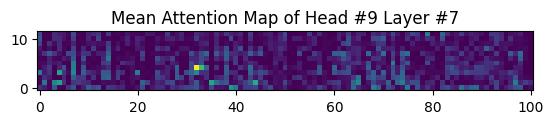

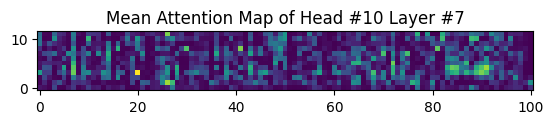

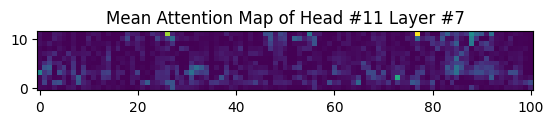

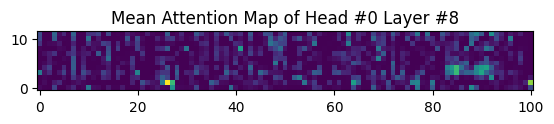

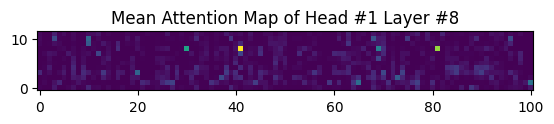

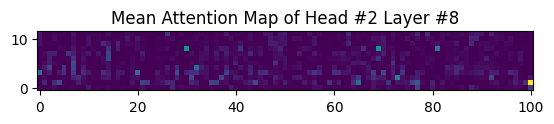

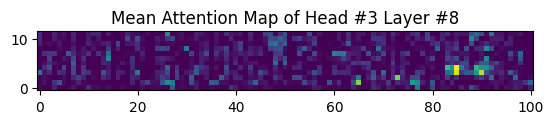

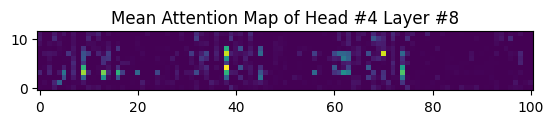

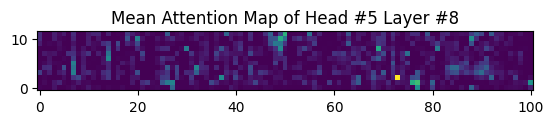

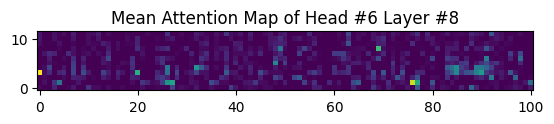

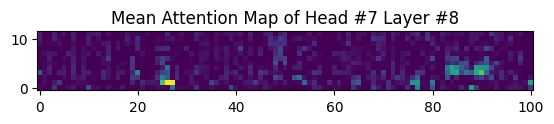

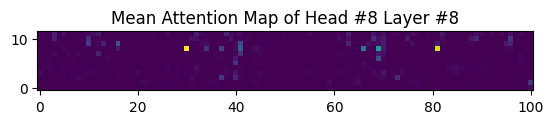

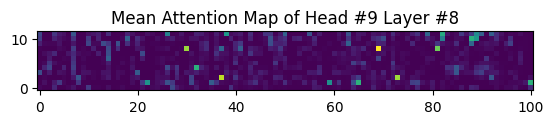

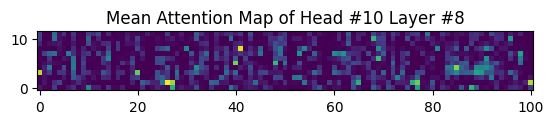

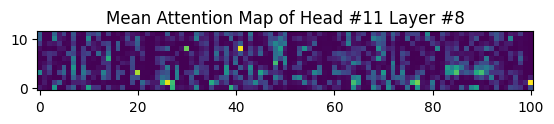

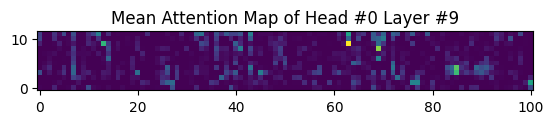

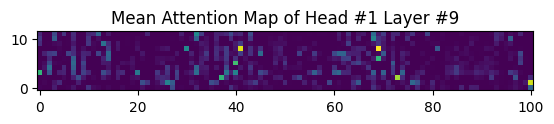

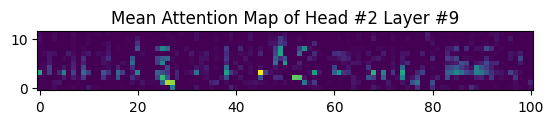

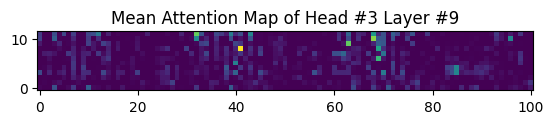

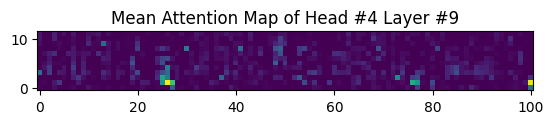

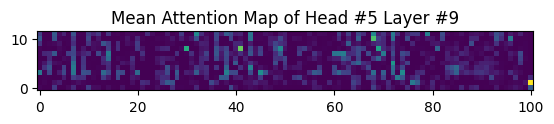

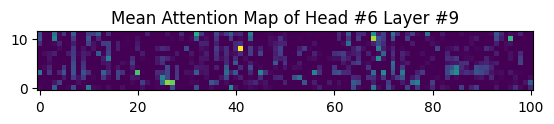

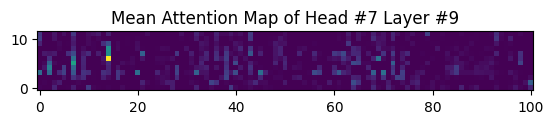

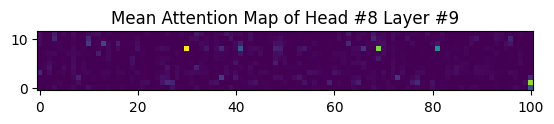

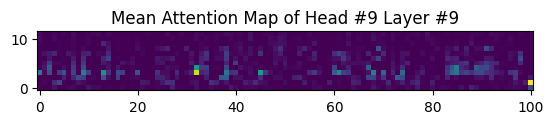

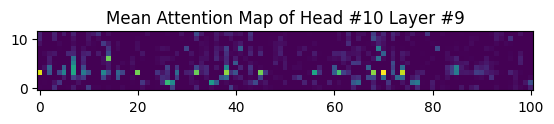

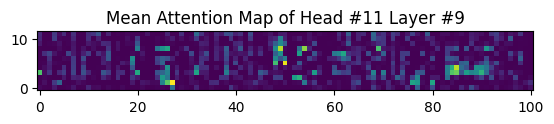

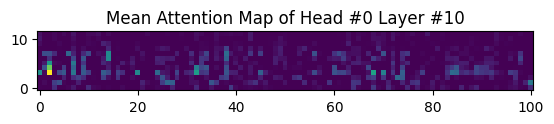

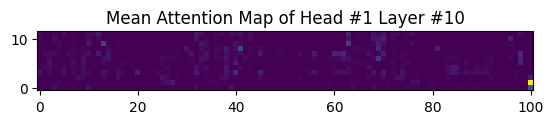

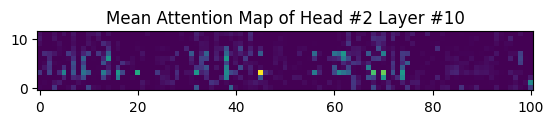

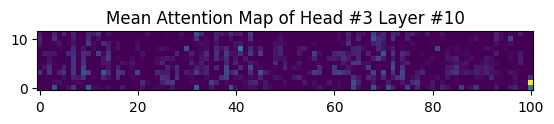

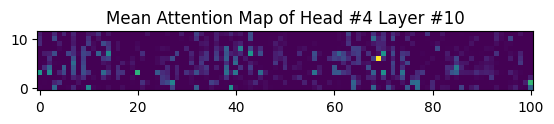

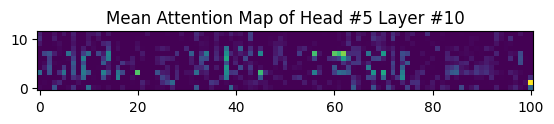

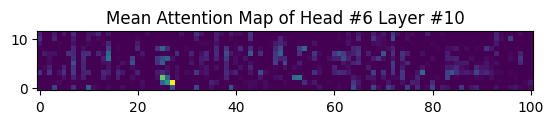

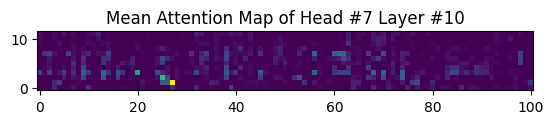

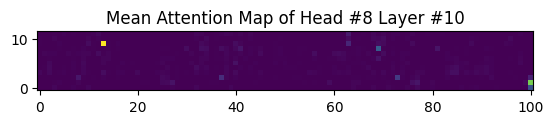

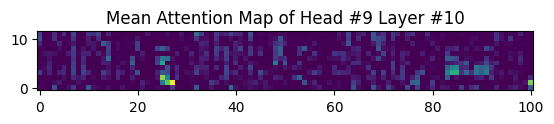

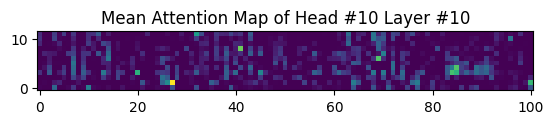

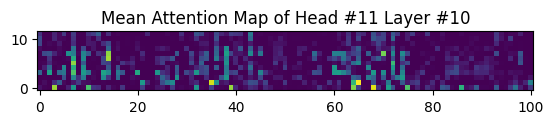

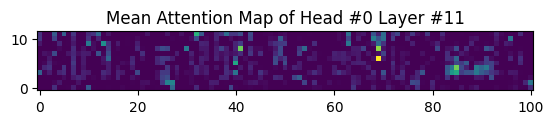

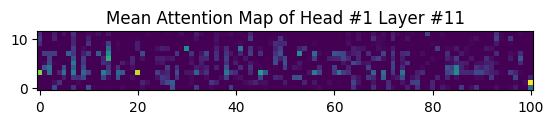

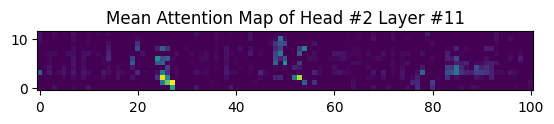

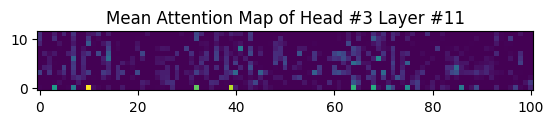

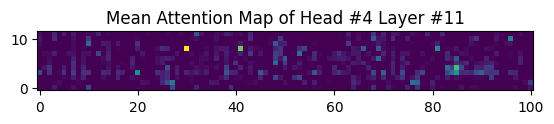

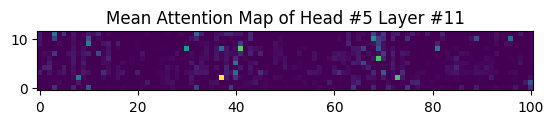

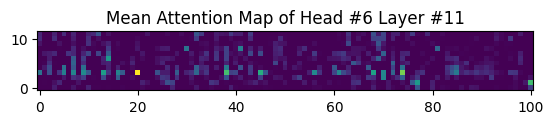

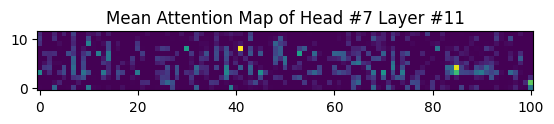

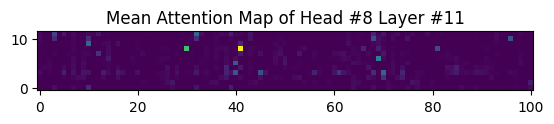

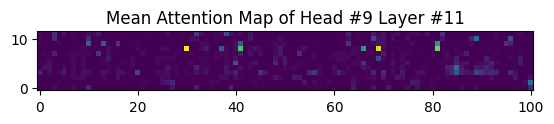

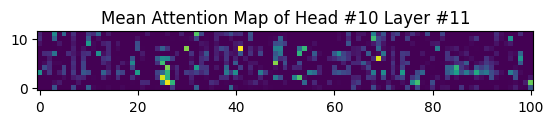

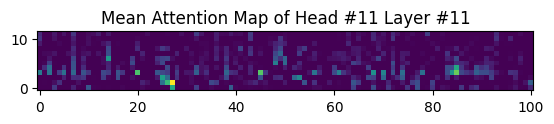

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)

# the layer of interest

#for i in range(12):
i = 10
att_map = att_list[i].data.cpu().numpy()
att_map = att_map[0]
att_map = np.mean(att_map[:, 0:2, :], axis=1)
att_map = att_map[:, 2:].reshape(12, 12, 101)
for j in range(12):
  plt.imshow(att_map[j], origin='lower')
  plt.title('Mean Attention Map of Head #{:d} Layer #{:d}'.format(j, i))
  plt.show()
  plt.close()